In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
from pysat.solvers import Solver
from collections import deque

In [2]:

def read_file(filename):
    with open(filename, 'r') as f:
      lines = f.readlines()
      matrix = np.zeros((len(lines), len(lines)))
      n = 0
      for line in lines:
        lst = line.split(',')
        lst_int = np.array(lst).astype(int)
        matrix[n] = lst_int
        n += 1
    return matrix, n


In [4]:


class Hashi_solver():
    def __init__(self, hashi_matrix = None, size = None):
        self.hashi_matrix = np.array(hashi_matrix) if hashi_matrix is not None else None
        self.size = size if size is not None else (self.hashi_matrix.shape[0] if self.hashi_matrix is not None else None)
        self.bridge = None
        self.cnf_clause = None
        self.var_index = {}   # name -> int
        self.rev_var = {}     # int -> name
        self.dimacs_path = None
        self.varmap_path = None
        self.islands = None
        self.edge_list = None
        self.solution = None
    def show_matrix(self):
        print(self.hashi_matrix)

    def __generate_bridge(self):
        """
        Scan the hashi_matrix to identify islands and potential edges
        Produces:
          - self.islands: {'pos':(col,row), 'D':value}
          - self.edge_list: {'u':, 'v':, 'orient': 'h'/'v', 'distance': int}
        """
        if self.hashi_matrix is None:
            raise ValueError("Hashi matrix is not defined.")
        grid = np.array(self.hashi_matrix)
        rows, cols = grid.shape
        # identify islands
        islands = {}
        idx = 1
        for r in range(rows):
            for c in range(cols):
                v = int(grid[r, c])
                if v>0:
                    islands[idx] = {'pos':(c+1, r+1), 'D':v}
                    idx += 1
        # helper maps
        by_row = {}
        by_col = {}
        for i,info in islands.items():
            c,r = info['pos']
            by_row.setdefault(r, []).append((c,i))
            by_col.setdefault(c, []).append((r,i))
        for r in by_row: by_row[r].sort()
        for c in by_col: by_col[c].sort()

        edges = {}
        for i,info in islands.items():
            c,r = info['pos']
            # row neighbors
            rowlist = by_row[r]
            ids = [idx for _,idx in rowlist]
            pos = ids.index(i)
            if pos>0:
                j = ids[pos-1]; a,b = min(i,j), max(i,j)
                edges[(a,b)] = {'u':a,'v':b, 'orient':'h', 'distance': abs(islands[i]['pos'][0]-islands[j]['pos'][0])}
            if pos < len(ids)-1:
                j = ids[pos+1]; a,b = min(i,j), max(i,j)
                edges[(a,b)] = {'u':a,'v':b, 'orient':'h', 'distance': abs(islands[i]['pos'][0]-islands[j]['pos'][0])}
            # column neighbors
            collist = by_col[c]
            ids2 = [idx for _,idx in collist]
            pos2 = ids2.index(i)
            if pos2>0:
                j = ids2[pos2-1]; a,b = min(i,j), max(i,j)
                edges[(a,b)] = {'u':a,'v':b, 'orient':'v', 'distance': abs(islands[i]['pos'][1]-islands[j]['pos'][1])}
            if pos2 < len(ids2)-1:
                j = ids2[pos2+1]; a,b = min(i,j), max(i,j)
                edges[(a,b)] = {'u':a,'v':b, 'orient':'v', 'distance': abs(islands[i]['pos'][1]-islands[j]['pos'][1])}

        edge_list = sorted(edges.values(), key=lambda x:(x['u'], x['v']))
        self.islands = islands
        self.edge_list = edge_list


    def generate_cnf(self, lazy = True, dimacs_path="/dimacs/hashi_solver.dimacs", varmap_path="/varmap/hashi_solver_varmap.txt"):
        """
        Generate CNF clauses for the current instance and write DIMACS + varmap.
        - lazy=True: not include connectivity clauses
        - lazy=False: include single-shot connectivity encoding
        Outputs:
          - cnf_clause for solver
          - writes DIMACS to dimacs_path and var mapping to varmap_path
        """
        if self.hashi_matrix is None:
            raise ValueError("Hashi matrix or bridge is not defined")
        self.__generate_bridge()
        clauses = []
        var_index = {}
        rev_var = {}
        var_counter = 1

        # 1) thermometer vars x_k_1, x_k_2
        for k,e in enumerate(self.edge_list, start=1):
            v1 = f"x_{k}_1"; v2 = f"x_{k}_2"
            var_index[v1] = var_counter; rev_var[var_counter] = v1; var_counter += 1
            var_index[v2] = var_counter; rev_var[var_counter] = v2; var_counter += 1

        # crossing detection
        def crosses(ea, eb):
            if ea['orient'] == eb['orient']: return False
            if ea['orient'] == 'v': ea, eb = eb, ea
            uh = self.islands[ea['u']]['pos']; vh = self.islands[ea['v']]['pos']
            uv = self.islands[eb['u']]['pos']; vv = self.islands[eb['v']]['pos']
            row = uh[1]; col = uv[0]
            minc = min(uh[0], vh[0]); maxc = max(uh[0], vh[0])
            minr = min(uv[1], vv[1]); maxr = max(uv[1], vv[1])
            inter = (col,row); endpoints = [uh, vh, uv, vv]
            return (col>minc and col<maxc and row>minr and row<maxr and inter not in endpoints)

        # 2) consistency x_k2 -> x_k1
        for k,_ in enumerate(self.edge_list, start=1):
            v1 = var_index[f"x_{k}_1"]; v2 = var_index[f"x_{k}_2"]
            clauses.append([-v2, v1])

        # 3) non-crossing
        for i,ea in enumerate(self.edge_list, start=1):
            for j,eb in enumerate(self.edge_list, start=1):
                if j<=i: continue
                if crosses(ea,eb):
                    clauses.append([-var_index[f"x_{i}_1"], -var_index[f"x_{j}_1"]])

        # 4) degree constraints by enumeration (each edge contributes 0/1/2)
        for u in self.islands:
            incident = []
            for k,e in enumerate(self.edge_list, start=1):
                if e['u']==u or e['v']==u:
                    incident.append((k,e))
            D = self.islands[u]['D']; n = len(incident)
            allowed = set()
            for prod in product([0,1,2], repeat=n):
                if sum(prod)==D:
                    allowed.add(prod)
            for prod in product([0,1,2], repeat=n):
                if prod in allowed: continue
                clause = []
                for val, (k_e) in zip(prod, incident):
                    k_idx = k_e[0]
                    v1 = var_index[f"x_{k_idx}_1"]; v2 = var_index[f"x_{k_idx}_2"]
                    if val==0:
                        clause.extend([v1, v2])
                    elif val==1:
                        clause.extend([-v1, v2])
                    else:
                        clause.extend([-v1, -v2])
                clause = list(set(clause))
                if clause: clauses.append(clause)

        next_var = var_counter

        # 5) connectivity
        if not lazy:
            # reach vars r_u
            reach_var = {}
            for u in self.islands:
                name = f"r_{u}"
                reach_var[u] = next_var; rev_var[next_var] = name; var_index[name] = next_var; next_var += 1
            root = min(self.islands.keys())
            clauses.append([reach_var[root]])  # root can reach

            # y variables for directed edge uses
            y_vars = {}
            for k,e in enumerate(self.edge_list, start=1):
                u = e['u']; v = e['v']
                name_uv = f"y_{k}_{u}_{v}"; name_vu = f"y_{k}_{v}_{u}"
                y_vars[(k,u,v)] = next_var; rev_var[next_var]=name_uv; var_index[name_uv]=next_var; next_var+=1
                y_vars[(k,v,u)] = next_var; rev_var[next_var]=name_vu; var_index[name_vu]=next_var; next_var+=1
                # y -> x_k_1
                clauses.append([-y_vars[(k,u,v)], var_index[f"x_{k}_1"]])
                clauses.append([-y_vars[(k,v,u)], var_index[f"x_{k}_1"]])
                # y -> r_u
                clauses.append([-y_vars[(k,u,v)], reach_var[u]])
                clauses.append([-y_vars[(k,v,u)], reach_var[v]])
                # (x_k_1 ^ r_u) -> y
                clauses.append([-var_index[f"x_{k}_1"], -reach_var[u], y_vars[(k,u,v)]])
                clauses.append([-var_index[f"x_{k}_1"], -reach_var[v], y_vars[(k,v,u)]])
                # y -> reach_v
                clauses.append([-y_vars[(k,u,v)], reach_var[v]])
                clauses.append([-y_vars[(k,v,u)], reach_var[u]])

            for v in self.islands:
                if v==root: continue
                incoming = []
                for k,e in enumerate(self.edge_list, start=1):
                    if e['u']==v:
                        incoming.append(y_vars[(k, e['v'], e['u'])])
                    elif e['v']==v:
                        incoming.append(y_vars[(k, e['u'], e['v'])])
                if incoming:
                    clauses.append([-reach_var[v]] + incoming)
                else:
                    # island has no incident edges -> impossible clause mean cant solve
                    clauses.append([1, -1])

        # write DIMACS and var map
        total_vars = next_var - 1
        dimacs_lines = [f"p cnf {total_vars} {len(clauses)}"]
        for cl in clauses:
            dimacs_lines.append(" ".join(str(l) for l in cl) + " 0")
        dimacs_text = "\n".join(dimacs_lines)
        with open(dimacs_path, "w") as f:
            f.write(dimacs_text)
        with open(varmap_path, "w") as f:
          for k, e in enumerate(self.edge_list, start=1):
              u = e['u']
              v = e['v']
              (x1, y1) = self.islands[u]['pos']
              (x2, y2) = self.islands[v]['pos']

              v1_id = var_index[f"x_{k}_1"]
              v2_id = var_index[f"x_{k}_2"]

              f.write(f"{v1_id} -> x_{k}_1 : ({x1},{y1}) <-> ({x2},{y2})\n")
              f.write(f"{v2_id} -> x_{k}_2 : ({x1},{y1}) <-> ({x2},{y2})\n")


        self.cnf_clause = clauses
        self.varmap = rev_var
        self.var_index = var_index
        self.rev_var = rev_var
        self.dimacs_path = dimacs_path
        self.varmap_path = varmap_path

    def solve_lazy(self, max_iter = 200, verbos = 10):
        if self.cnf_clause is None:
            self.generate_cnf(lazy=True)
        solver = Solver(name='glucose4')
        for cl in self.cnf_clause:
            solver.add_clause(cl)
        iters = 0
        while True:
            iters += 1
            if iters > max_iter:
                solver.delete()
                return {'status':'UNKNOWN', 'reason':'max_iter_exceeded'}
            sat = solver.solve()
            if not sat:
                solver.delete()
                return {'status':'UNSAT'}
            model = solver.get_model()  # list of ints
            # compute edge values
            edge_vals = {}
            for k,e in enumerate(self.edge_list, start=1):
                v1 = self.var_index[f"x_{k}_1"]; v2 = self.var_index[f"x_{k}_2"]
                val = 0
                if v1 in model:
                    val = 1
                if v2 in model:
                    val += 1
                edge_vals[k] = val
              # build adjacency and check connectivity
            adj = {u:set() for u in self.islands}
            for k,e in enumerate(self.edge_list, start=1):
                if edge_vals[k] > 0:
                    adj[e['u']].add(e['v']); adj[e['v']].add(e['u'])
              # BFS components
            visited=set()
            comps=[]
            for u in self.islands:
                if u not in visited:
                    q = deque([u]); comp=set()
                    while q:
                        x = q.popleft()
                        if x in visited: continue
                        visited.add(x); comp.add(x)
                        for nb in adj[x]:
                            if nb not in visited:
                                q.append(nb)
                    comps.append(comp)
            if len(comps) == 1:
                solver.delete()
                # success, write bridges as (u,v,count)
                bridges = []
                for k,e in enumerate(self.edge_list, start=1):
                    if edge_vals[k] > 0:
                        bridges.append((e['u'], e['v'], edge_vals[k]))
                self.solution = {'bridges':bridges, 'model':model}
                return {'status':'SAT', 'bridges':bridges, 'model':model}
            # else all clause
            comp = min([c for c in comps if len(c) < len(self.islands)], key=lambda s: len(s))
            cut_edges = []
            for k,e in enumerate(self.edge_list, start=1):
                if (e['u'] in comp and e['v'] not in comp) or (e['v'] in comp and e['u'] not in comp):
                    cut_edges.append(k)
            if not cut_edges:
                solver.delete()
                return {'status':'UNSAT', 'reason':'no_cut_edges_but_disconnected'}
            clause = [ self.var_index[f"x_{k}_1"] for k in cut_edges ]
            solver.add_clause(clause)
            if iters % verbos == 0:
                print(f"[iter {iters}] added connectivity clause OR over edges {cut_edges}")
        # end loop

    def draw_hashi(self, own_grid = None):
        #import matplotlib.pyplot as plt
        n = self.size
        plt.figure(figsize=(n, n))
        ax = plt.gca()
        grid = None
        if own_grid is not None:
              grid = own_grid
        elif self.solution is not None:
              grid = self.structure_solver()
        for row in range(n):
            for col in range(n):
                value = int(self.hashi_matrix[row, col])
                if value != 0:
                    circle = plt.Circle((col + 0.5, n - 1 - row + 0.5), 0.49, color='blue', fill=False)
                    ax.add_patch(circle)
                    ax.text(col + 0.5, n - 1 - row + 0.5, str(int(value)), size = 20, color='black', ha='center', va='center')
                else:
                    if grid is not None:
                        if grid[row][col] == '-':
                            line = plt.Line2D([col, col + 1], [n - 1 - row + 0.5, n - 1 - row + 0.5], color='red')
                        elif grid[row][col] == '=':
                            line = plt.Line2D([col, col + 1], [n - 1 - row + 0.4, n - 1 - row + 0.4], color='red')
                            ax.add_line(line)
                            line = plt.Line2D([col, col + 1], [n - 1 - row + 0.6, n - 1 - row + 0.6], color='red')
                        elif grid[row][col] == '|':
                            line = plt.Line2D([col + 0.5, col + 0.5], [n - 1 - row, n - 1 - row + 1], color='red')
                        elif grid[row][col] == '$':
                            line = plt.Line2D([col + 0.4, col + 0.4], [n - 1 - row, n - 1 - row + 1], color='red')
                            ax.add_line(line)
                            line = plt.Line2D([col + 0.6, col + 0.6], [n - 1 - row, n - 1 - row + 1], color='red')
                        if grid[row][col] != '0':
                            ax.add_line(line)
        ax.set_xlim(0, n); ax.set_ylim(0, n)
        ax.set_xticks(np.arange(0, n + 1)); ax.set_yticks(np.arange(0, n + 1))
        plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticklabels([]); ax.set_yticklabels([])
        plt.show()

    def structure_solver(self):
        """
        where “|” means one vertical bridge, “$” means two vertical bridges, “-” means one horizontal
        bridge, and “=” means two horizontal bridges.
        """
        if self.solution is None:
            raise ValueError("No solution found. Call solve_lazy() first.")

        n = self.size

        grid = [["0" for _ in range(n)] for _ in range(n)]

        for info in self.islands.values():
            x, y = info["pos"]   # (x,y) Cartesian
            val = info["D"]
            r = y - 1
            c = x - 1
            grid[r][c] = str(val)

        for (u, v, count) in self.solution["bridges"]:
            (x1, y1) = self.islands[u]["pos"]
            (x2, y2) = self.islands[v]["pos"]

            r1, c1 = y1 - 1, x1 - 1
            r2, c2 = y2 - 1, x2 - 1

            # row
            if r1 == r2:
                row = r1
                cmin = min(c1, c2)
                cmax = max(c1, c2)

                symbol = "-" if count == 1 else "="

                for c in range(cmin + 1, cmax):
                    grid[row][c] = symbol

            # column
            elif c1 == c2:
                col = c1
                rmin = min(r1, r2)
                rmax = max(r1, r2)

                symbol = "|" if count == 1 else "$"

                for r in range(rmin + 1, rmax):
                    grid[r][col] = symbol

        with open("hashi_solution.txt", "w") as f:
            for row in grid:
                f.write("[")
                for i in range(len(row)):
                    charac = row[i]
                    if i < len(row) - 1:
                        f.write('\"' + charac + "\" , ")
                    else:
                        f.write('\"' + charac + "\"")
                f.write("]\n")
            f.close()
        return grid


In [8]:
path = "hashi_test.txt"
matrix, n = read_file('input/hashi_test.txt')
name = path.split('/')[-1].split('.')[0]
Hashi = Hashi_solver(matrix, n)
Hashi.show_matrix()

[[1. 0. 1. 0. 0.]
 [0. 0. 0. 2. 0.]
 [2. 0. 3. 0. 1.]
 [0. 0. 0. 2. 0.]
 [0. 0. 2. 0. 2.]]


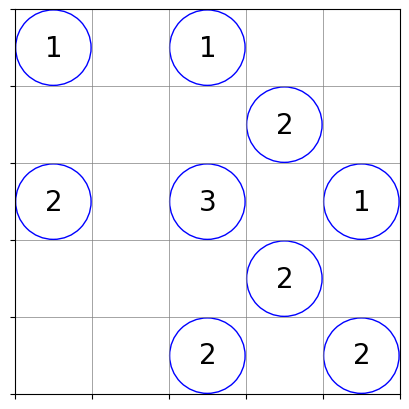

In [9]:
Hashi = Hashi_solver(matrix, n)
Hashi.draw_hashi()

In [32]:
# Sinh CNF lazy (không ép liên thông trực tiếp)
Hashi.generate_cnf(lazy=True,
                                   dimacs_path=name + "_cnf.dimacs",
                                   varmap_path= name + "_varmap.txt")

In [33]:
solution = Hashi.solve_lazy()
print(solution)
#Hashi.structure_solver()

{'status': 'UNSAT', 'reason': 'no_cut_edges_but_disconnected'}


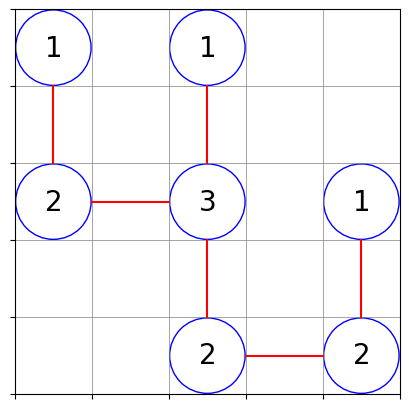

In [21]:
Hashi.structure_solver()
Hashi.draw_hashi()

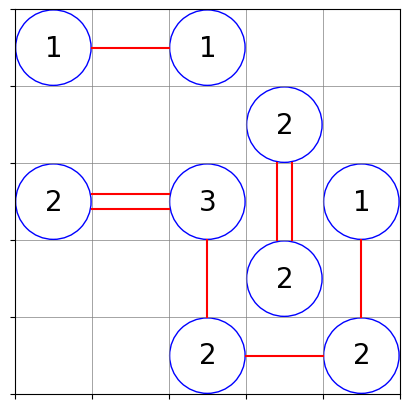

In [36]:
grid = [["1" , "-" , "1" , "0" , "0"], ["0" , "0" , "0" , "2" , "0"],
        ["2" , "=" , "3" , "$" , "0"], ["0" , "0" , "|" , "2" , "|"],
        ["0" , "0" , "2" , "-" , "2"]]
Hashi.draw_hashi(grid)

In [72]:
import random

class HashiGenerator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = [[0 for _ in range(width)] for _ in range(height)]

    def generate(self):
        nodes = []
        for r in range(0, self.height, 2): # Cách 1 dòng có đảo
            for c in range(0, self.width, 2): # Cách 1 cột có đảo
                if random.random() < 0.9:
                    nodes.append((r, c))

        h_bridges = {}
        v_bridges = {}

        # Duyệt qua các node để nối ngang
        for r, c in nodes:
            next_c = c + 2
            if (r, next_c) in nodes:
                val = random.choices([0, 1, 2], weights=[0.3, 0.35, 0.35])[0]
                if val > 0:
                    h_bridges[(r, c)] = val

        # Duyệt qua các node để nối dọc
        for r, c in nodes:
            # Tìm hàng xóm bên dưới
            next_r = r + 2
            if (next_r, c) in nodes:
                # Random nối dọc
                val = random.choices([0, 1, 2], weights=[0.3, 0.35, 0.35])[0]
                if val > 0:
                    v_bridges[(r, c)] = val

        final_grid = [[0 for _ in range(self.width)] for _ in range(self.height)]

        valid_islands_count = 0

        for r, c in nodes:
            count = 0
            # + Cầu nối sang trái (từ node bên trái nối sang)
            if (r, c-2) in h_bridges: count += h_bridges[(r, c-2)]
            # + Cầu nối sang phải (tự mình nối sang phải)
            if (r, c) in h_bridges: count += h_bridges[(r, c)]
            # + Cầu nối lên trên
            if (r-2, c) in v_bridges: count += v_bridges[(r-2, c)]
            # + Cầu nối xuống dưới
            if (r, c) in v_bridges: count += v_bridges[(r, c)]

            if count > 0:
                final_grid[r][c] = count
                valid_islands_count += 1

        if valid_islands_count > 0:
            start_node = None
            for r in range(self.height):
                for c in range(self.width):
                    if final_grid[r][c] > 0:
                        start_node = (r, c)
                        break
                if start_node: break

            # BFS đếm số đảo đi tới được
            visited = set()
            queue = [start_node]
            visited.add(start_node)
            count_visited = 0

            while queue:
                ur, uc = queue.pop(0)
                count_visited += 1

                # Trái
                if (ur, uc-2) in h_bridges and (ur, uc-2) not in visited:
                    visited.add((ur, uc-2)); queue.append((ur, uc-2))
                # Phải
                if (ur, uc) in h_bridges and (ur, uc+2) not in visited:
                    visited.add((ur, uc+2)); queue.append((ur, uc+2))
                # Trên
                if (ur-2, uc) in v_bridges and (ur-2, uc) not in visited:
                    visited.add((ur-2, uc)); queue.append((ur-2, uc))
                # Dưới
                if (ur, uc) in v_bridges and (ur+2, uc) not in visited:
                    visited.add((ur+2, uc)); queue.append((ur+2, uc))

            # Nếu số đảo đi được < tổng số đảo -> Không liên thông -> Generate lại
            if count_visited < valid_islands_count:
                return self.generate()

        return final_grid

    def print_grid(self, grid):
        for row in grid:
            print(" , ".join(str(x) for x in row))
        print("\n")

sizes = [
    (7, 7), (7, 7),
    (9, 9), (9, 9),
    (11, 11), (11, 11),
    (13, 13), (13, 13),
    (17, 17),
    (20, 20)
]

for i, (h, w) in enumerate(sizes):
    print(f"TEST CASE #{i+1}")
    gen = HashiGenerator(w, h)
    grid = gen.generate()
    gen.print_grid(grid)

TEST CASE #1
3 , 0 , 1 , 0 , 3 , 0 , 2
0 , 0 , 0 , 0 , 0 , 0 , 0
4 , 0 , 4 , 0 , 5 , 0 , 1
0 , 0 , 0 , 0 , 0 , 0 , 0
2 , 0 , 4 , 0 , 5 , 0 , 2
0 , 0 , 0 , 0 , 0 , 0 , 0
2 , 0 , 4 , 0 , 4 , 0 , 2


TEST CASE #2
3 , 0 , 2 , 0 , 2 , 0 , 2
0 , 0 , 0 , 0 , 0 , 0 , 0
4 , 0 , 0 , 0 , 0 , 0 , 3
0 , 0 , 0 , 0 , 0 , 0 , 0
2 , 0 , 3 , 0 , 3 , 0 , 5
0 , 0 , 0 , 0 , 0 , 0 , 0
0 , 0 , 4 , 0 , 4 , 0 , 3


TEST CASE #3
3 , 0 , 3 , 0 , 2 , 0 , 4 , 0 , 2
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
3 , 0 , 1 , 0 , 0 , 0 , 5 , 0 , 5
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
3 , 0 , 0 , 0 , 3 , 0 , 5 , 0 , 4
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
4 , 0 , 1 , 0 , 4 , 0 , 4 , 0 , 2
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
1 , 0 , 0 , 0 , 4 , 0 , 3 , 0 , 0


TEST CASE #4
2 , 0 , 1 , 0 , 0 , 0 , 3 , 0 , 3
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
4 , 0 , 5 , 0 , 2 , 0 , 2 , 0 , 3
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
2 , 0 , 4 , 0 , 5 , 0 , 3 , 0 , 3
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0
4 , 0 , 5 , 0 , 3 , 0 , 4 , 0 , 4
0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0


In [74]:
size = 17
gen_test = HashiGenerator(size, size)
grid = gen_test.generate()
grid = np.array(grid)
print(grid)

[[2 0 0 0 1 0 3 0 5 0 3 0 4 0 3 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 5 0 5 0 3 0 5 0 3 0 2 0 2 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 5 0 7 0 3 0 2 0 0 0 2 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 0 5 0 7 0 5 0 5 0 0 0 2 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 5 0 6 0 5 0 4 0 0 0 3 0 3 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 3 0 2 0 4 0 5 0 5 0 6 0 5 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [5 0 4 0 3 0 3 0 5 0 5 0 7 0 5 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 5 0 4 0 3 0 5 0 2 0 2 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 5 0 2 0 2 0 3 0 3 0 0 0 2 0 1]]


[[2 0 0 0 1 0 3 0 5 0 3 0 4 0 3 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 5 0 5 0 3 0 5 0 3 0 2 0 2 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 5 0 7 0 3 0 2 0 0 0 2 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 0 5 0 7 0 5 0 5 0 0 0 2 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 5 0 6 0 5 0 4 0 0 0 3 0 3 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 3 0 2 0 4 0 5 0 5 0 6 0 5 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [5 0 4 0 3 0 3 0 5 0 5 0 7 0 5 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 5 0 4 0 3 0 5 0 2 0 2 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 5 0 2 0 2 0 3 0 3 0 0 0 2 0 1]]


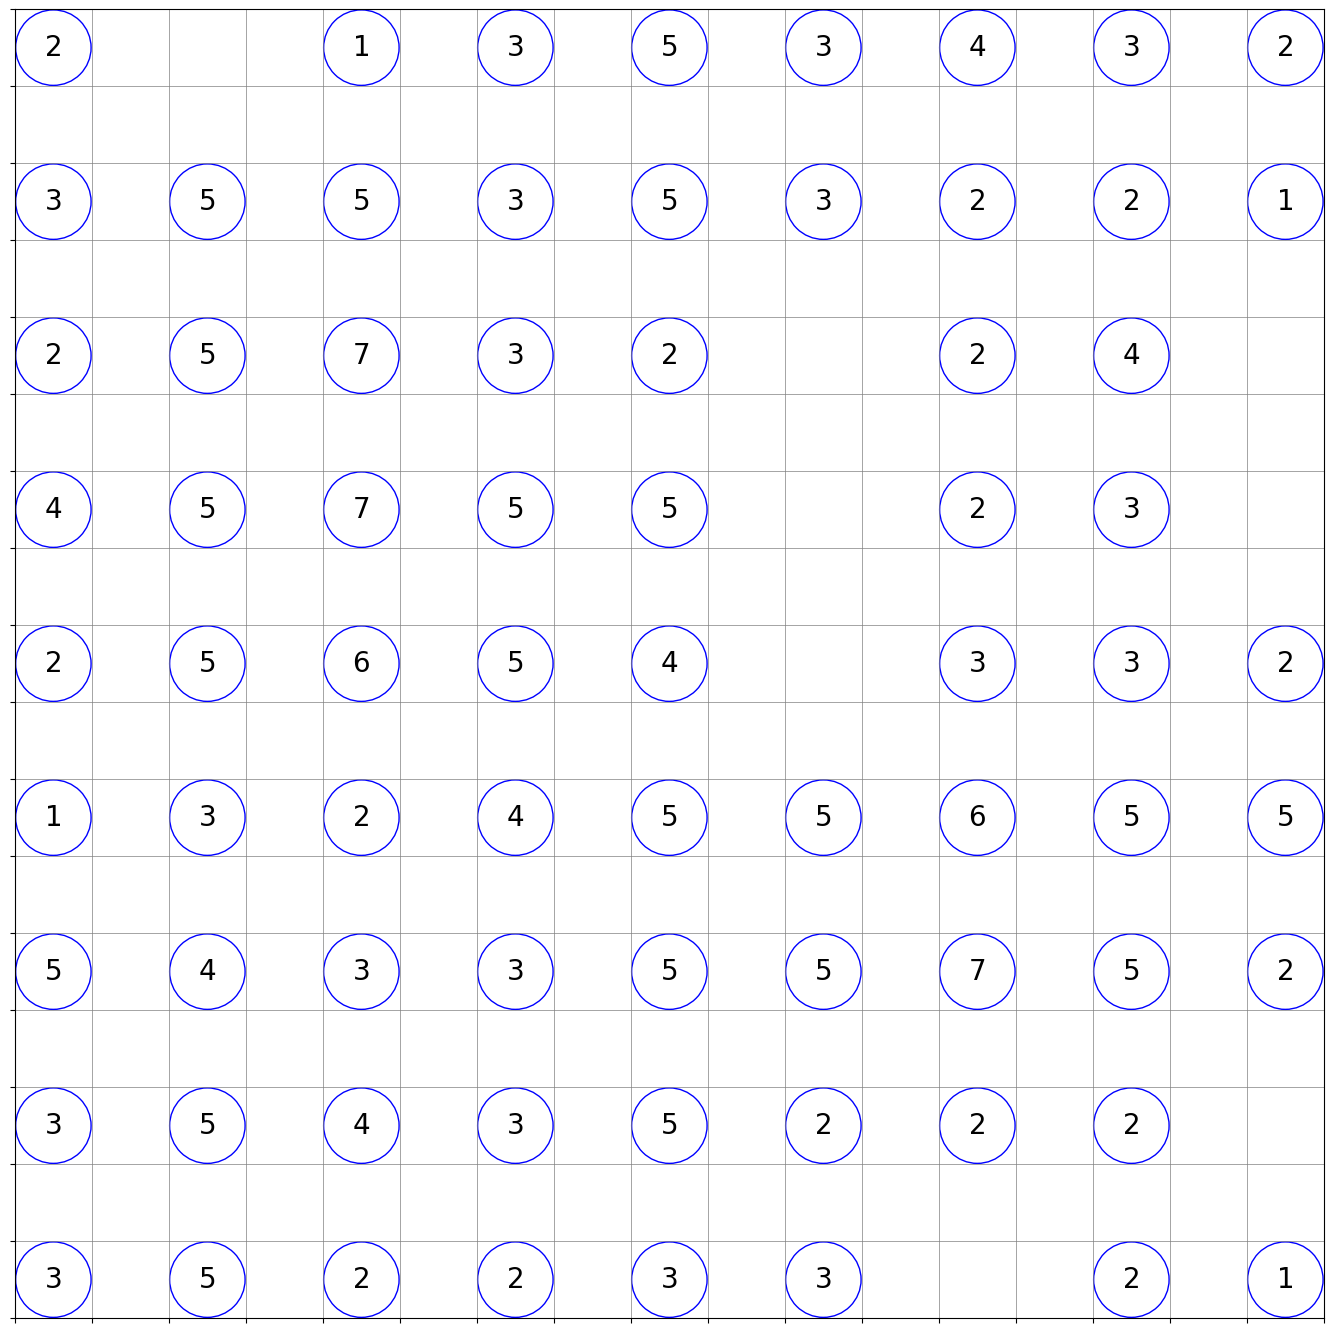

In [75]:
Hashi_11 = Hashi_solver(grid, size)
Hashi_11.show_matrix()
Hashi_11.draw_hashi()

In [76]:
Hashi_11.generate_cnf(lazy=True,
                                   dimacs_path="test_" + str(size) + "_cnf.dimacs",
                                   varmap_path="test_" + str(size) + "_varmap.txt")

In [77]:
print(Hashi_11.solve_lazy())

{'status': 'SAT', 'bridges': [(1, 9, 2), (2, 11, 1), (3, 4, 2), (3, 12, 1), (4, 5, 1), (4, 13, 2), (5, 6, 1), (5, 14, 1), (6, 7, 2), (6, 15, 1), (7, 8, 1), (8, 17, 1), (9, 10, 1), (10, 11, 2), (10, 19, 2), (11, 20, 2), (12, 13, 2), (13, 14, 1), (14, 45, 1), (15, 23, 1), (16, 24, 2), (18, 19, 1), (18, 25, 1), (19, 20, 1), (19, 26, 1), (20, 21, 2), (20, 27, 2), (21, 28, 1), (22, 29, 2), (23, 30, 1), (24, 31, 2), (25, 26, 1), (25, 32, 2), (26, 27, 2), (26, 33, 1), (27, 28, 1), (27, 34, 2), (28, 29, 2), (28, 35, 1), (29, 36, 1), (30, 37, 1), (31, 38, 1), (33, 34, 2), (33, 41, 2), (34, 35, 1), (34, 42, 1), (35, 36, 1), (35, 43, 2), (36, 44, 2), (37, 46, 2), (38, 39, 1), (38, 47, 1), (39, 48, 1), (40, 49, 1), (41, 42, 1), (43, 44, 2), (44, 45, 1), (45, 46, 2), (45, 54, 1), (46, 55, 2), (47, 48, 2), (47, 56, 2), (48, 57, 2), (49, 50, 2), (49, 58, 2), (50, 51, 1), (50, 59, 1), (51, 52, 2), (52, 53, 1), (53, 54, 2), (53, 62, 2), (54, 55, 2), (55, 56, 2), (55, 64, 1), (56, 65, 1), (58, 66, 1), (

[['2', '0', '0', '0', '1', '0', '3', '=', '5', '-', '3', '-', '4', '=', '3', '-', '2'], ['$', '0', '0', '0', '|', '0', '|', '0', '$', '0', '|', '0', '|', '0', '0', '0', '|'], ['3', '-', '5', '=', '5', '0', '3', '=', '5', '-', '3', '0', '2', '0', '2', '0', '1'], ['0', '0', '$', '0', '$', '0', '0', '0', '0', '0', '|', '0', '|', '0', '$', '0', '0'], ['2', '-', '5', '-', '7', '=', '3', '0', '2', '0', '|', '0', '2', '0', '4', '0', '0'], ['|', '0', '|', '0', '$', '0', '|', '0', '$', '0', '|', '0', '|', '0', '$', '0', '0'], ['4', '-', '5', '=', '7', '-', '5', '=', '5', '0', '|', '0', '2', '0', '3', '0', '0'], ['$', '0', '|', '0', '$', '0', '|', '0', '|', '0', '|', '0', '|', '0', '|', '0', '0'], ['2', '0', '5', '=', '6', '-', '5', '-', '4', '0', '|', '0', '3', '0', '3', '-', '2'], ['0', '0', '$', '0', '|', '0', '$', '0', '$', '0', '|', '0', '$', '0', '|', '0', '|'], ['1', '0', '3', '-', '2', '0', '4', '=', '5', '-', '5', '=', '6', '0', '5', '=', '5'], ['|', '0', '0', '0', '0', '0', '0', '0', '

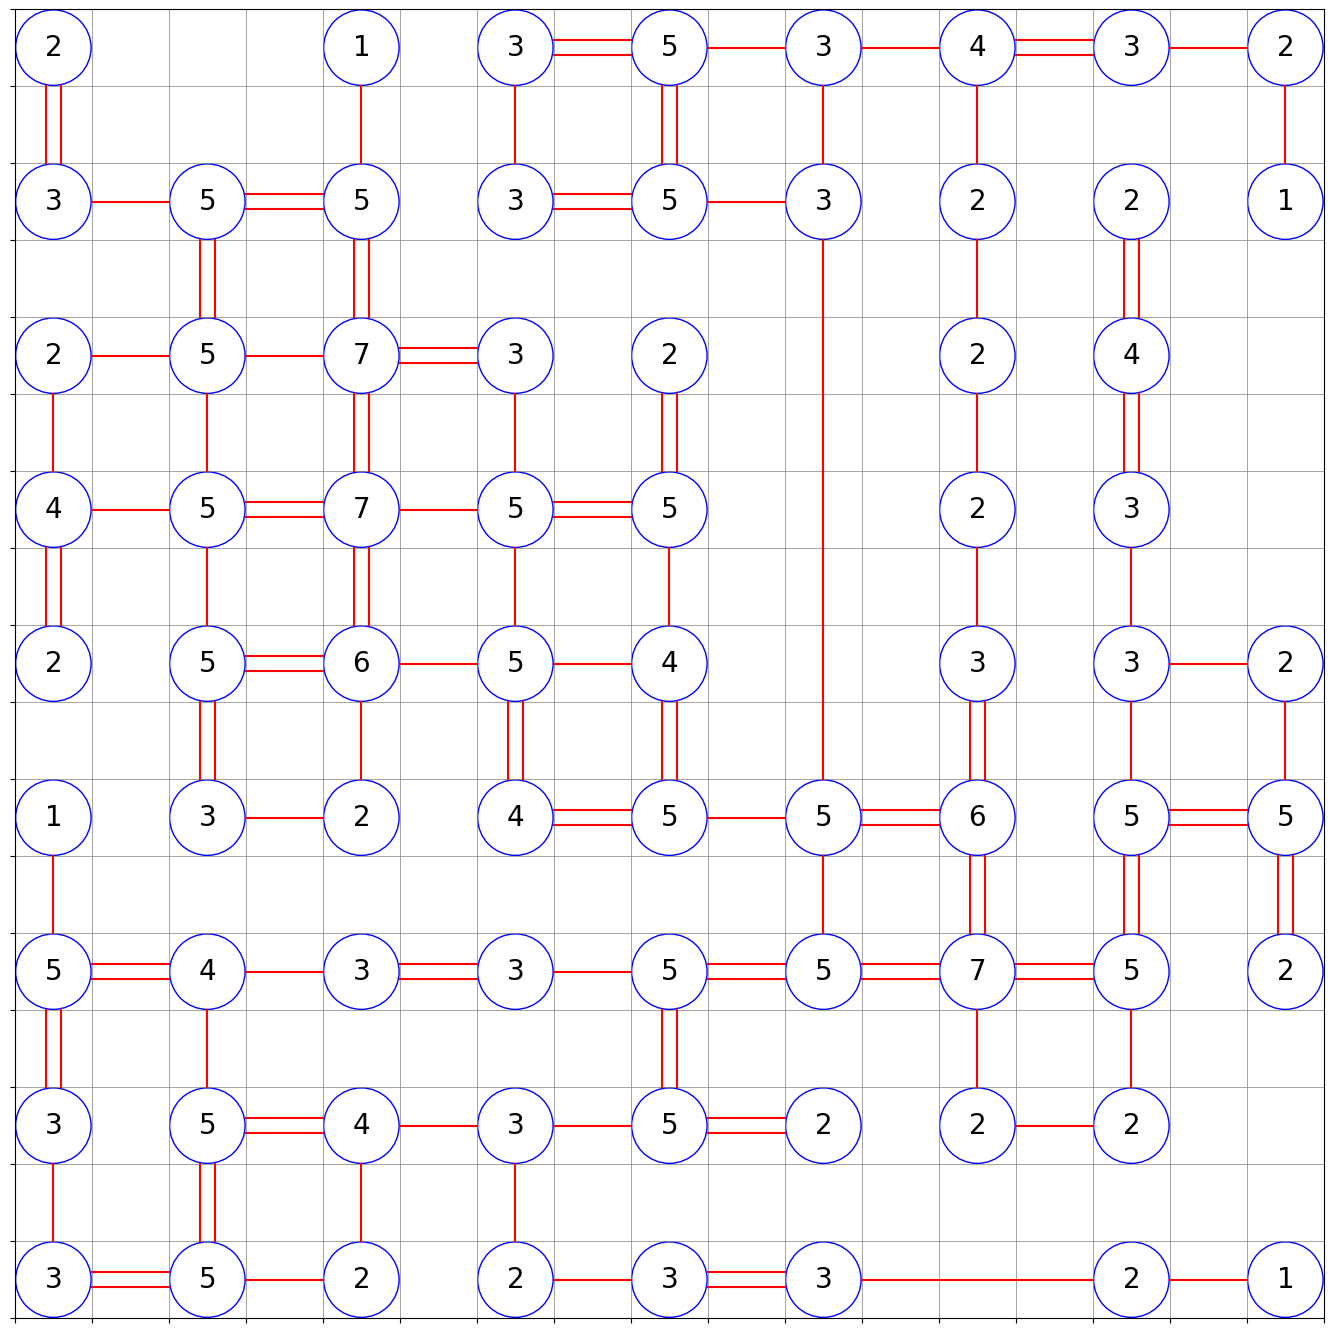

In [78]:
print(Hashi_11.structure_solver())
Hashi_11.draw_hashi()